<!-- ![](./texmf/logos/header.png) -->
<img src="./texmf/logos/header.png",width=100%>

# The Twinkles 1 Strong Lens Population

*Bryce Kalmbach, Phil Marshall, Curtis McCully and others*

The Twinkles 1 field is overloaded with supernovae and strongly lensed quasars. In this Note we describe the input lens population, and how the lens systems are 'sprinkled' into the PhoSim instance catalogs, having been matched by redshift and stellar mass.

## The OM10 Lensed Quasar Mock Catalog

PJM: Brief description, with links.

**JBK**: Selection of Twinkles subset.

### The Twinkles-OM10 Catalog

The lens system catalog used by Twinkles is found in the data folder of the repository and is labeled as [twinkles_lenses_v2.fits](https://github.com/LSSTDESC/Twinkles/blob/master/data/twinkles_lenses_v2.fits). We started by selecting the subset of 872 OM10 lenses that made up rung 4 in the [Strong Lens Time Delay Challenge](http://timedelaychallenge.org/index.html) ([Liao et al. 2015](https://arxiv.org/abs/1409.1254)). This set was chosen since it matches the LSST best (discussed in issue [#117](https://github.com/LSSTDESC/Twinkles/issues/117)).  **Question for PJM: What does matches LSST best mean?** However, the original OM10 catalog is incomplete and lacks sizes for the foreground lens galaxies. In addition, our image simulations require an SED for the lens galaxy of each system. Therefore, we decided to assign stellar masses to our OM10 lens galaxies based upon SL2S data and then use this information to assign an SED and radial size from an appropriate CATSIM galaxy.

#### Matching CATSIM galaxies to lensed systems

We performed the matching using code in a jupyter notebook [here](https://github.com/LSSTDESC/Twinkles/blob/master/examples/notebooks/MatchingLensGalaxies.ipynb). The process involved three main steps:

1. Use SL2S data to generate a Gaussian Mixture Model (GMM) to estimate stellar mass of lens galaxies based upon redshift and velocity dispersion.
    * We use the data from Table 3 of [Sonnenfeld et al. (2013)](https://arxiv.org/abs/1307.4759).
    * Derive the GMM using the [XDGMM](https://github.com/tholoien/XDGMM) and [empriciSN](https://github.com/tholoien/empiriciSN) packages by Tom Holoien.
2. Assign a stellar mass to the OM10 systems based upon this GMM and the OM10 redshifts and velocity dispersions.
3. Use the updated OM10 catalog with stellar masses, redshifts and ellipticities to match against CATSIM galaxies and use best fit galaxies to add SED and radius information to OM10 catalog.
    * Matched OM10 galaxies to CATSIM galaxies with a 20% error limit on the three matching parameters.
    * 11 OM10 lens galaxies did not have matches within 20% in all three parameters to a CATSIM galaxy. These were not included in the final catalog.

After the matching process we had a final catalog of 861 OM10 systems with additional size and SED information needed to generate images. This final catalog was then used as the input for `The Sprinkler`.

## `The Sprinkler` Concept and Code

**JBK**: Introduce `The Sprinkler` concept, including input and output, and any principles involved. Note: This is mostly taken straight from previous documentation [here](https://github.com/LSSTDESC/Twinkles/blob/master/doc/SLSimDocumentation/strong_lensing_review.ipynb).

`The Sprinkler` is the [code](https://github.com/LSSTDESC/Twinkles/blob/master/python/desc/twinkles/sprinkler.py) that matches OM10 lens systems to AGNs in an instance catalog and replaces the instance catalog AGN with one of our lensed systems in the final PhoSim input catalog. To do this we add a step in the CATSIM `final pass` method when creating instance catalogs for PhoSim input and manipulate the array of catalog results before they are printed to file. The first step is loading the OM10-Twinkles catalog we described in the previous section. We then go through the instance catalog AGNs one at a time and see if they match a lens system from our OM10-Twinkles catalog. The matching is done by taking the redshift and magnitude of the CATSIM AGN and selecting any available lens systems with a source AGN that has a redshift within 0.1 dex and an LSST magnorm value (magnitude in a simulated filter with one bin at 500nm) within .25 mags.

Once the possible matches to a given instance catalog AGN are found there is a chance that it will be replaced that is set by the density parameter in the sprinkler class. In the current Twinkles run it is set at 1.0 so that 198 lens systems are sprinkled into the Twinkles instance catalogs.

If the AGN is chosen to be sprinkled then we proceed with the sprinkler and if there are multiple matches from the OM10-Twinkles catalog we randomly choose one to use as we proceed. First, we remove any disc and bulge information for that galaxy from the instance catalog leaving only the AGN data and copy this AGN entry creating 2 or 4 entries in the catalog depending upon the number of images the OM10 system we are sprinkling in has in total. Next we use the OM10 data for each image to shift the location of the AGN in each image to the correct location and adjust the magnitude for each entry depending on the OM10 magnification parameter for each AGN image. At this point we also adjust the time delay for each image with OM10 info and give all the images the same source redshift from the OM10 entry. Once the new entries are ready they are appended to the instance catalog with a new instance catalog id tag that gives us the ID of the Bulge galaxy in the instance catalog to which it is associated and the ID number of the OM10-Twinkles catalog system that is used.

The next step is to take the original entry in the instance catalog and add in the information for the foreground lens galaxy. Therefore, in this step the AGN and Disc data for the original galaxy are cleared and the redshift and magnitude for the lens galaxy from the OM10 system is added into the instance catalog. Here we also add in the radius of the lens galaxy and the sed file we want to use (the information added to the original OM10 systems in the process described in the last section). We also add in the OM10 position angles and ellipticities at this point.

Once we have gone through this process for all AGN in the instance catalog then we return to the normal instance catalog processing to write the information out to file.

**JBK**: Show Sprinkler operating on OM10 sample made in previous section and producing an example (or the actual!) instance catalog. Note: I am basically going to follow the example [here](../../../examples/notebooks/Sort_Objects_in_ICs.ipynb) to process the instance catalog before the results section. 

> The matching of lensed systems seemed to take place outside `the sprinkler` - why is this? Do we want to refactor so that `the sprinkler` handles everything? I think this might be helpful...

Now we will use the sprinkler in the Twinkles code to generate a full instance catalog for the Twinkles field. To set up Twinkles you can follow the instructions [here](../../Setup/Getting_started_on_your_laptop.rst#gravitational-lens-sprinkling-setup). Below we will create an instance catalog using the LSST OpSim database `minion_1016` and for visit `230`.

In [1]:
%run ../../../bin/generatePhosimInput.py 230 --opsimDB minion_1016_sqlite.db --outfile 230_test.txt 

/Users/Bryce/lsst/DarwinX86/sims_catalogs/2.3.3.sims/python/lsst/sims/catalogs/db/dbConnection.py:470: UserWarning: Duplicate object type id 25 specified: 
Output object ids may not be unique.
This may not be a problem if you do not want globally unique id values
  'want globally unique id values')
/Users/Bryce/lsst/DarwinX86/sims_catalogs/2.3.3.sims/python/lsst/sims/catalogs/db/dbConnection.py:470: UserWarning: Duplicate object type id 40 specified: 
Output object ids may not be unique.
This may not be a problem if you do not want globally unique id values
  'want globally unique id values')
/Users/Bryce/miniconda2/lib/python2.7/site-packages/matplotlib/__init__.py:1401: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


will generate pointing for 230 and write to filename 230_test.txt
{'mjd': 59580.139555000002, 'pointingRA': 53.009138473031555, 'rotSkyPos': 256.7507531819308, 'boundLength': 0.29999999999999999, 'skyBrightness': 21.232126999999998, 'OpsimMetaData': {'sunAlt': -0.57134799999999997, 'sunAz': 3.5626009999999999, 'rotSkyPos': 4.4811459999999999, 'slewDist': 0.75588900000000003, 'mieScatter': 1103.8354549999999, 'moonIllum': 6.9999999999999994e-05, 'visitExpTime': 30.0, 'lst': 1.4007689999999999, 'azimuth': 4.7159180000000003, 'moonDec': -0.41008299999999998, 'humidity': 0.0, 'ditheredRA': 0.90797615810743615, 'moonPhase': 3.8193649999999999, 'phaseAngle': 157.460083, 'index': 0, 'filtSkyBrightness': 21.232126999999998, 'rawSeeing': 0.86628499999999997, 'altitude': 1.1611579999999999, 'fieldRA': 0.92518400000000001, 'rotTelPos': 0.0, 'obsHistID': 230, 'moonAlt': -0.630629, 'solarElong': 111.110772, 'moonRA': 4.4750880000000004, 'FWHMeff': 1.1219680000000001, 'airmass': 1.0901989999999999, 

/Users/Bryce/lsst/DarwinX86/sqlalchemy/1.0.8.lsst3+3/lib/python/SQLAlchemy-1.0.8-py2.7-macosx-10.6-x86_64.egg/sqlalchemy/sql/elements.py:3779: SAWarning: Textual SQL expression 'ra between 52.671111 and ...' should be explicitly declared as text('ra between 52.671111 and ...') (this warning may be suppressed after 10 occurrences)
  {"expr": util.ellipses_string(element)})
/Users/Bryce/lsst/DarwinX86/sqlalchemy/1.0.8.lsst3+3/lib/python/SQLAlchemy-1.0.8-py2.7-macosx-10.6-x86_64.egg/sqlalchemy/sql/elements.py:3779: SAWarning: Textual SQL expression 'gmag > 11.0' should be explicitly declared as text('gmag > 11.0') (this warning may be suppressed after 10 occurrences)
  {"expr": util.ellipses_string(element)})
/Users/Bryce/lsst/DarwinX86/sqlalchemy/1.0.8.lsst3+3/lib/python/SQLAlchemy-1.0.8-py2.7-macosx-10.6-x86_64.egg/sqlalchemy/sql/sqltypes.py:565: SAWarning: Dialect sqlite+pysqlite does *not* support Decimal objects natively, and SQLAlchemy must convert from floating point - rounding err

writing galCat


/Users/Bryce/lsst/DarwinX86/sqlalchemy/1.0.8.lsst3+3/lib/python/SQLAlchemy-1.0.8-py2.7-macosx-10.6-x86_64.egg/sqlalchemy/sql/elements.py:3779: SAWarning: Textual SQL expression 'g_ab > 11.0' should be explicitly declared as text('g_ab > 11.0') (this warning may be suppressed after 10 occurrences)
  {"expr": util.ellipses_string(element)})


Running sprinkler. Catalog Length:  10000
Gone through  0  lines of catalog.
Gone through  100  lines of catalog.


/Users/Bryce/miniconda2/lib/python2.7/site-packages/numpy/core/records.py:507: FutureWarning: Numpy has detected that you may be viewing or writing to an array returned by selecting multiple fields in a structured array. 

This code may break in numpy 1.13 because this will return a view instead of a copy -- see release notes for details.
  return obj.view(dtype=(self.dtype.type, obj.dtype))


Running sprinkler. Catalog Length:  10000
Gone through  0  lines of catalog.
Gone through  100  lines of catalog.
Running sprinkler. Catalog Length:  10000
Gone through  0  lines of catalog.
Gone through  100  lines of catalog.
Running sprinkler. Catalog Length:  10000
Gone through  0  lines of catalog.
Gone through  100  lines of catalog.
Running sprinkler. Catalog Length:  10000
Gone through  0  lines of catalog.
Gone through  100  lines of catalog.
Running sprinkler. Catalog Length:  10000
Gone through  0  lines of catalog.
Gone through  100  lines of catalog.
Running sprinkler. Catalog Length:  10000
Gone through  0  lines of catalog.
Gone through  100  lines of catalog.
Running sprinkler. Catalog Length:  10000
Gone through  0  lines of catalog.
Gone through  100  lines of catalog.
Running sprinkler. Catalog Length:  10000
Gone through  0  lines of catalog.
Gone through  100  lines of catalog.
Running sprinkler. Catalog Length:  10000
Gone through  0  lines of catalog.
Gone throug

Now that we have an instance catalog let's go through it and find the sprinkled objects.

### Parsing the Instance Catalog

First I will read in the instance catalog and separate out the sprinkled objects from the rest of the catalog.

In [2]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
filename = '230_test.txt'

In [4]:
i = 0
not_star_rows = []
not_galaxy_rows = []
not_agn_rows = []
not_sne_rows = []
with open(filename, 'r') as f:
    for line in f:
        new_str = line.split(' ')
        #Skip through the header
        if len(new_str) < 4:
            not_star_rows.append(i)
            not_galaxy_rows.append(i)
            not_agn_rows.append(i)
            not_sne_rows.append(i)
            i+=1
            continue
        if new_str[5].startswith('starSED'):
            #star_rows.append(i)
            not_galaxy_rows.append(i)
            not_agn_rows.append(i)
            not_sne_rows.append(i)
        elif new_str[5].startswith('galaxySED'):
            #galaxy_rows.append(i)
            not_star_rows.append(i)
            not_agn_rows.append(i)
            not_sne_rows.append(i)
        elif new_str[5].startswith('agnSED'):
            #agn_rows.append(i)
            not_star_rows.append(i)
            not_galaxy_rows.append(i)
            not_sne_rows.append(i)
        elif new_str[5].startswith('spectra_files'):
            #sne_rows.append(i)
            not_star_rows.append(i)
            not_galaxy_rows.append(i)
            not_agn_rows.append(i)
        i += 1

We'll focus on the galaxy and AGN objects since those are the types of objects we sprinkled in to the catalog.

In [5]:
df_galaxy = pd.read_csv(filename, delimiter=' ', header=None, 
                        names=['prefix', 'uniqueId', 'raPhoSim', 'decPhoSim', 
                              'phoSimMagNorm', 'sedFilepath',
                              'redshift', 'shear1', 'shear2', 'kappa', 
                              'raOffset', 'decOffset', 'spatialmodel', 
                              'majorAxis', 'minorAxis', 'positionAngle', 'sindex',
                              'internalExtinctionModel', 'internalAv', 'internalRv',
                              'galacticExtinctionModel', 'galacticAv', 'galacticRv'], 
                        skiprows=not_galaxy_rows)

df_agn = pd.read_csv(filename, delimiter=' ', header=None, 
                     names=['prefix', 'uniqueId', 'raPhoSim', 'decPhoSim', 
                            'phoSimMagNorm', 'sedFilepath', 'redshift', 
                            'shear1', 'shear2', 'kappa', 'raOffset', 'decOffset',
                            'spatialmodel', 'internalExtinctionModel',
                            'galacticExtinctionModel', 'galacticAv', 'galacticRv'],
                     skiprows = not_agn_rows)

### Sort out sprinkled Strong Lensing Systems

Now we will pick out the pieces of strongly lensed systems that were sprinkled into the instance catalogs for the Twinkles project.

#### Lensed AGN
We start with the Lensed AGN. In Twinkles Instance Catalogs the lensed AGN have larger `uniqueId`s than normal since we added information about the systems into the `uniqueId`s. We use this to find them in the AGN dataframe.

In [6]:
sprinkled_agn = df_agn[df_agn['uniqueId'] > 20000000000]

Below we see a pair of lensed images from a double.

In [7]:
sprinkled_agn[:2]

,prefix,uniqueId,raPhoSim,decPhoSim,phoSimMagNorm,sedFilepath,redshift,shear1,shear2,kappa,raOffset,decOffset,spatialmodel,internalExtinctionModel,galacticExtinctionModel,galacticAv,galacticRv
338,object,213934178332,53.052941,-27.703314,21.101459,agnSED/agn.spec.gz,0.48,0,0,0,0,0,point,none,CCM,0.029784,3.1
339,object,213934179356,53.052396,-27.702922,22.611757,agnSED/agn.spec.gz,0.48,0,0,0,0,0,point,none,CCM,0.029791,3.1


Now we will extract the extra information we have stored in the `uniqueId`. This information is the Twinkles System number in our custom OM10 catalog in the `data` directory in Twinkles and the Twinkles Image Number which identifies which image in that particular system refers to that line in the catalog.

In [8]:
# This step undoes the step in CatSim that gives each component of a galaxy a different offset
twinkles_nums = []
for agn_id in sprinkled_agn['uniqueId']:
    twinkles_ids = np.right_shift(agn_id-28, 10)
    twinkles_nums.append(twinkles_ids)
    
#This parses the information added in the last 4 digits of the unshifted ID
twinkles_system_num = []
twinkles_img_num = []
for lens_system in twinkles_nums:
    lens_system = str(lens_system)
    twinkles_id = lens_system[-4:]
    twinkles_id = np.int(twinkles_id)
    twinkles_base = np.int(np.floor(twinkles_id/4))
    twinkles_img = twinkles_id % 4
    twinkles_system_num.append(twinkles_base)
    twinkles_img_num.append(twinkles_img)

We once again look at the two images we showed earlier. We see that they are image 0 and image 1 from Twinkles System 24.

In [9]:
print twinkles_system_num[:2], twinkles_img_num[:2]

[24, 24] [0, 1]


We now add this information into our sprinkled AGN dataframe and reset the indices.

In [10]:
sprinkled_agn = sprinkled_agn.reset_index(drop=True)
sprinkled_agn['twinkles_system'] = twinkles_system_num
sprinkled_agn['twinkles_img_num'] = twinkles_img_num
sprinkled_agn.iloc[:2, [1, 2, 3, -2, -1]]

,uniqueId,raPhoSim,decPhoSim,twinkles_system,twinkles_img_num
0,213934178332,53.052941,-27.703314,24,0
1,213934179356,53.052396,-27.702922,24,1


The last step is to now add a column with the lens galaxy `uniqueId` for each system so that we can cross-reference between the lensed AGN and the lens galaxy dataframe we will create next. We start by finding the `uniqueId`s for the lens galaxies.

In [11]:
#The lens galaxy ids do not have the extra 4 digits at the end so we remove them
#and then do the shift back to the `uniqueID`.
lens_gal_ids = np.left_shift((np.array(twinkles_nums))/10000, 10) + 26

sprinkled_agn['lens_galaxy_uID'] = lens_gal_ids

We now see that the same system has the same lens galaxy `uniqueId` as we expect.

In [12]:
sprinkled_agn.iloc[:2, [1, 2, 3, -3, -2, -1]]

,uniqueId,raPhoSim,decPhoSim,twinkles_system,twinkles_img_num,lens_galaxy_uID
0,213934178332,53.052941,-27.703314,24,0,21393434
1,213934179356,53.052396,-27.702922,24,1,21393434


#### Lens Galaxies

Now we will create a dataframe with the Lens Galaxies.

In [13]:
lens_gal_locs = []
for idx in lens_gal_ids:
    lens_gal_locs.append(np.where(df_galaxy['uniqueId'] == idx)[0])

lens_gals = df_galaxy.iloc[np.unique(lens_gal_locs)]
lens_gals = lens_gals.reset_index(drop=True)

We now have the lens galaxies in their own dataframe that can be joined on the lensed AGN dataframe by the `uniqueId`.

In [14]:
lens_gals[lens_gals['uniqueId'] == sprinkled_agn['lens_galaxy_uID'][0]]

,prefix,uniqueId,raPhoSim,decPhoSim,phoSimMagNorm,sedFilepath,redshift,shear1,shear2,kappa,...,majorAxis,minorAxis,positionAngle,sindex,internalExtinctionModel,internalAv,internalRv,galacticExtinctionModel,galacticAv,galacticRv
0,object,21393434,53.052488,-27.702974,17.830105,galaxySED/Inst.25E09.02Z.spec.gz,0.184,0,0,0,...,1.612616,1.153254,56.84685,4,CCM,0.2,3.1,CCM,0.02979,3.1


And we can check how many systems there are by checking the length of this dataframe and it will show that we have 198 lens systems in the Twinkles field!

In [15]:
len(lens_gals)

198

## Results

JBK: Plots showing successful instance catalog generation: 1) Example system, showing sky positions of lensed quasar images and lens galaxy, compared to standard OM10 representation. 2) Distributions of lens galaxy and source quasar magnitude, to show that matching works well. etc.

### Compare catalog positions to OM10

We want to show that the positions of the images in our lens systems in the catalogs are where they should be according to the OM10 systems we are using. Here we will use an example system from the catalog to show that we have lined up our catalog objects correctly.

In [16]:
def offset_on_sky(ra, dec, ra0, dec0, units='degrees'):
    """
    Subtract off a reference sky position and convert to simple cartesians in arcsec:
    
    Parameters
    ----------
    ra, dec : float, float
        Feature positions (degrees)
    ra0, dec0 : float, float
        Reference position (degrees)
    units : string
        'degrees' or 'radians'
    
    Returns
    -------
    x, y : float, float
        Offset position in righthanded cartesians, and units of arcsec
    """
    if units == 'radians':
        ra, dec = np.degrees(ra), np.degrees(dec)
        
    y = 3600.0 * (dec - dec0)
    x = 3600.0 * (ra - ra0) * np.cos(np.radians(dec0))
    return x, y

In [17]:
# Load Twinkles OM10 database
from astropy.io import fits
om10_db = fits.open('../../../data/twinkles_lenses_v2.fits')

In [18]:
# We'll pick a Quad system for more fun
sprinkled_agn[16:20]

,prefix,uniqueId,raPhoSim,decPhoSim,phoSimMagNorm,sedFilepath,redshift,shear1,shear2,kappa,raOffset,decOffset,spatialmodel,internalExtinctionModel,galacticExtinctionModel,galacticAv,galacticRv,twinkles_system,twinkles_img_num,lens_galaxy_uID
16,object,1257605247004,53.140369,-27.688755,23.305929,agnSED/agn.spec.gz,0.62,0,0,0,0,0,point,none,CCM,0.029121,3.1,31,0,125760538
17,object,1257605248028,53.141059,-27.688468,22.744297,agnSED/agn.spec.gz,0.62,0,0,0,0,0,point,none,CCM,0.029120,3.1,31,1,125760538
18,object,1257605249052,53.141089,-27.688154,22.502861,agnSED/agn.spec.gz,0.62,0,0,0,0,0,point,none,CCM,0.029126,3.1,31,2,125760538
19,object,1257605250076,53.140447,-27.688057,23.598845,agnSED/agn.spec.gz,0.62,0,0,0,0,0,point,none,CCM,0.029134,3.1,31,3,125760538


In [19]:
# These are the example lens galaxy and lensed AGN images from above
example_lensed_agn = sprinkled_agn.iloc[16:20, [1, 2, 3, -3, -2, -1]]
example_lensed_agn = example_lensed_agn.reset_index(drop=True)
example_lens_galaxy = lens_gals[lens_gals['uniqueId'] == example_lensed_agn['lens_galaxy_uID'][0]]
example_lensed_agn['lens_ra'] = np.array([example_lens_galaxy['raPhoSim'].iloc[0]]*4)
example_lensed_agn['lens_dec'] = np.array([example_lens_galaxy['decPhoSim'].iloc[0]]*4)

In [20]:
example_lensed_agn

,uniqueId,raPhoSim,decPhoSim,twinkles_system,twinkles_img_num,lens_galaxy_uID,lens_ra,lens_dec
0,1257605247004,53.140369,-27.688755,31,0,125760538,53.140651,-27.688312
1,1257605248028,53.141059,-27.688468,31,1,125760538,53.140651,-27.688312
2,1257605249052,53.141089,-27.688154,31,2,125760538,53.140651,-27.688312
3,1257605250076,53.140447,-27.688057,31,3,125760538,53.140651,-27.688312


In [21]:
# Match the lens system to its OM10 source
twinkles_sys_num = example_lensed_agn['twinkles_system'].iloc[0]
om10_sys = om10_db[1].data[om10_db[1].data['twinklesId'] == twinkles_sys_num]
om10_sys

FITS_rec([ (447252, 0, 4,  0.202,  281.8383,  0.3325666, -136.1489,  0.06078814,  54.97539,  0.62,  0.01993577, -0.2136398,  23.41,  22.30149,  3.152606, [-0.8915,  1.3049,  1.394 , -0.653 ], [-1.5949, -0.5538,  0.5766,  0.9183], [ 2.7759, -4.2353,  5.3534, -1.5119], [  0.   ,  17.956,  16.262,  31.911], [ 0.,  0.,  0.,  0.], [ 0.,  0.,  0.,  0.],  685.897339,  990.987244, -23.1394997,  17.0428391,  0.20200001,  1399.73,  890.815,  0.,  3673.45,  0.,  2.0383899,  0., 31, 'Inst.40E09.02Z.spec')], 
      dtype=(numpy.record, [('LENSID', '>i4'), ('FLAGTYPE', '>i2'), ('NIMG', '>i2'), ('ZLENS', '>f8'), ('VELDISP', '>f8'), ('ELLIP', '>f8'), ('PHIE', '>f8'), ('GAMMA', '>f8'), ('PHIG', '>f8'), ('ZSRC', '>f8'), ('XSRC', '>f8'), ('YSRC', '>f8'), ('MAGI_IN', '>f8'), ('MAGI', '>f8'), ('IMSEP', '>f8'), ('XIMG', '>f8', (4,)), ('YIMG', '>f8', (4,)), ('MAG', '>f8', (4,)), ('DELAY', '>f8', (4,)), ('KAPPA', '>f8', (4,)), ('FSTAR', '>f8', (4,)), ('DD', '>f8'), ('DDLUM', '>f8'), ('ABMAG_I', '>f8'), ('APMA

In [22]:
# Calculate the offsets from the lens galaxy position
offset_x1, offset_y1 = offset_on_sky(example_lensed_agn['raPhoSim'].iloc[0], example_lensed_agn['decPhoSim'].iloc[0],
                                     example_lensed_agn['lens_ra'].iloc[0], example_lensed_agn['lens_dec'].iloc[0])
offset_x2, offset_y2 = offset_on_sky(example_lensed_agn['raPhoSim'].iloc[1], example_lensed_agn['decPhoSim'].iloc[1],
                                     example_lensed_agn['lens_ra'].iloc[1], example_lensed_agn['lens_dec'].iloc[1])
offset_x3, offset_y3 = offset_on_sky(example_lensed_agn['raPhoSim'].iloc[2], example_lensed_agn['decPhoSim'].iloc[2],
                                     example_lensed_agn['lens_ra'].iloc[2], example_lensed_agn['lens_dec'].iloc[2])
offset_x4, offset_y4 = offset_on_sky(example_lensed_agn['raPhoSim'].iloc[3], example_lensed_agn['decPhoSim'].iloc[3],
                                     example_lensed_agn['lens_ra'].iloc[3], example_lensed_agn['lens_dec'].iloc[3])

In [23]:
# Let's use the OM10 tools here since it has a nice plotting method
import om10
db = om10.DB(catalog='../../../data/twinkles_lenses_v2.fits')
lens = db.get_lens(om10_sys['LENSID'])

Now that we have all the information ready. We'll first make a plot of the OM10 system from the OM10 data and then in the second plot we'll remake the same plot but overlay the positions of the catalog images on top.

om10.plot_lens: plotting image configuration of lens ID  447252
om10.plot_lens: lens, image magnitudes: 17.0428391 [ 22.30149046  21.84278955  21.58842576  22.96119233]
om10.plot_lens: figure saved to file: om10_qso_ID=447252.png


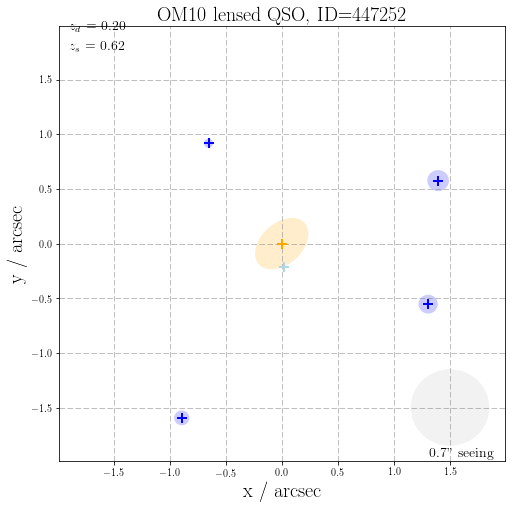

In [24]:
om10.plot_lens(lens)

om10.plot_lens: plotting image configuration of lens ID  447252
om10.plot_lens: lens, image magnitudes: 17.0428391 [ 22.30149046  21.84278955  21.58842576  22.96119233]
om10.plot_lens: figure saved to file: om10_qso_ID=447252.png


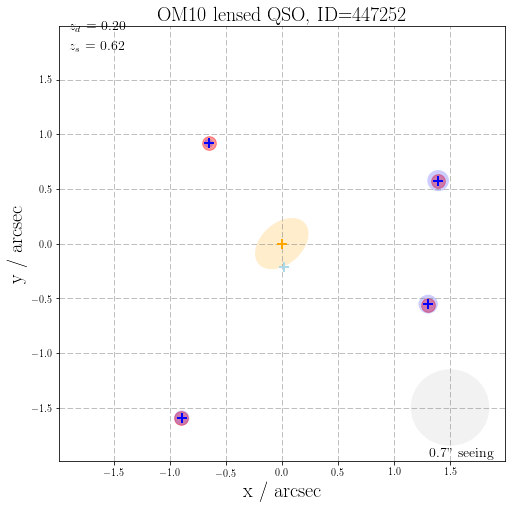

In [25]:
om10.plot_lens(lens)
plt.scatter(offset_x1, offset_y1, c='r', marker='o', s=188, alpha=0.4, label='Catalog Image 1')
plt.scatter(offset_x2, offset_y2, c='r', marker='o', s=188, alpha=0.4, label='Catalog Image 2')
plt.scatter(offset_x3, offset_y3, c='r', marker='o', s=188, alpha=0.4, label='Catalog Image 3')
plt.scatter(offset_x4, offset_y4, c='r', marker='o', s=188, alpha=0.4, label='Catalog Image 4')

The blue crosses are the OM10 positions and the red circles are the image positions from the Twinkles instance catalog we created. Our catalog sources match the positions relative to the lens galaxy that the OM10 data gives.

### Comparing Magnitudes of Sources

In order to compare magnitudes we first need to convert our catalog magnitudes which are in a delta function magnitude at 500 nm we call the `imsimband` to the I magnitude of OM10. When converting magnitudes in the `sprinkler` we assumed that I magnitude was comparable to the LSST *i* band. Here we will do the same and convert `imsimband` magnitudes from the catalog to LSST *i* magnitudes using the SEDs associated with the catalog objects.

In [26]:
import re
from lsst.utils import getPackageDir
from lsst.sims.photUtils.Sed import Sed
from lsst.sims.photUtils.BandpassDict import BandpassDict
from lsst.sims.photUtils.Bandpass import Bandpass
from future.utils import iteritems
from lsst.sims.utils import SpecMap

In [27]:
agn_fname = str(getPackageDir('sims_sed_library') + '/agnSED/agn.spec.gz')
bandpassDict = BandpassDict.loadTotalBandpassesFromFiles(bandpassNames=['i'])
imsimband = Bandpass()
imsimband.imsimBandpass()

In [28]:
sprinkled_agn.iloc[0]

prefix                                 object
uniqueId                         213934178332
raPhoSim                              53.0529
decPhoSim                            -27.7033
phoSimMagNorm                         21.1015
sedFilepath                agnSED/agn.spec.gz
redshift                                 0.48
shear1                                      0
shear2                                      0
kappa                                       0
raOffset                                    0
decOffset                                   0
spatialmodel                            point
internalExtinctionModel                  none
galacticExtinctionModel                   CCM
galacticAv                          0.0297841
galacticRv                                3.1
twinkles_system                            24
twinkles_img_num                            0
lens_galaxy_uID                      21393434
Name: 0, dtype: object

In [31]:
catalog_agn_mags = []
om10_agn_mags = []
lens_gal_om10_sys = dict()
for idx, spr_agn_row in sprinkled_agn.iterrows():

    agn_sed = Sed()
    agn_sed.readSED_flambda(agn_fname)
    
    fluxnorm = agn_sed.calcFluxNorm(spr_agn_row['phoSimMagNorm'], imsimband)
    agn_sed.redshiftSED(spr_agn_row['redshift'])
    agn_sed.multiplyFluxNorm(fluxnorm)
    catalog_agn_mags.append(bandpassDict.magDictForSed(agn_sed)['i'])
    db_row = np.where(om10_db[1].data['twinklesId'] == spr_agn_row['twinkles_system'])[0][0]
    mag_adjust = 2.5*np.log10(np.abs(om10_db[1].data[db_row]['MAG']))
    om10_mag = om10_db[1].data[db_row]['MAGI_IN']-mag_adjust[spr_agn_row['twinkles_img_num']]
    om10_agn_mags.append(om10_mag)
    if spr_agn_row['lens_galaxy_uID'] not in lens_gal_om10_sys.keys():
        lens_gal_om10_sys[str(spr_agn_row['lens_galaxy_uID'])] = db_row

/Users/Bryce/miniconda2/lib/python2.7/site-packages/ipykernel/__main__.py:14: RuntimeWarning: divide by zero encountered in log10


In [125]:
specFileStart = 'Burst'
for key, val in sorted(iteritems(SpecMap.subdir_map)):
    if re.match(key, specFileStart):
        galSpecDir = str(val)
galDir = str(getPackageDir('sims_sed_library') + '/' + galSpecDir + '/')
LRG_name = str(galDir + 'Burst.25E09.1Z.spec')

In [127]:
lens_gals.iloc[0]


prefix                                               object
uniqueId                                           21393434
raPhoSim                                            53.0525
decPhoSim                                           -27.703
phoSimMagNorm                                       17.8301
sedFilepath                galaxySED/Inst.25E09.02Z.spec.gz
redshift                                              0.184
shear1                                                    0
shear2                                                    0
kappa                                                     0
raOffset                                                  0
decOffset                                                 0
spatialmodel                                       sersic2d
majorAxis                                           1.61262
minorAxis                                           1.15325
positionAngle                                       56.8469
sindex                                  

In [32]:
catalog_lens_gal_mags = []
om10_lens_gal_mags = []
for idx, lens_gal_row in lens_gals.iterrows():

    lens_sed = Sed()
    #lens_sed.readSED_flambda(LRG_name)
    lens_sed.readSED_flambda(str(getPackageDir('sims_sed_library') + '/' + lens_gal_row['sedFilepath']))
    
    fluxnorm = lens_sed.calcFluxNorm(lens_gal_row['phoSimMagNorm'], imsimband)
    lens_sed.redshiftSED(lens_gal_row['redshift'])
    lens_sed.multiplyFluxNorm(fluxnorm)
    catalog_lens_gal_mags.append(bandpassDict.magDictForSed(lens_sed)['i'])
    db_row = lens_gal_om10_sys[str(lens_gal_row['uniqueId'])]
    om10_mag = om10_db[1].data[db_row]['APMAG_I']
    om10_lens_gal_mags.append(om10_mag)

Now that we have magnitudes in the same band for the catalog and OM10 objects we can plot the distributions from the systems in the catalog to those they are based upon in OM10.

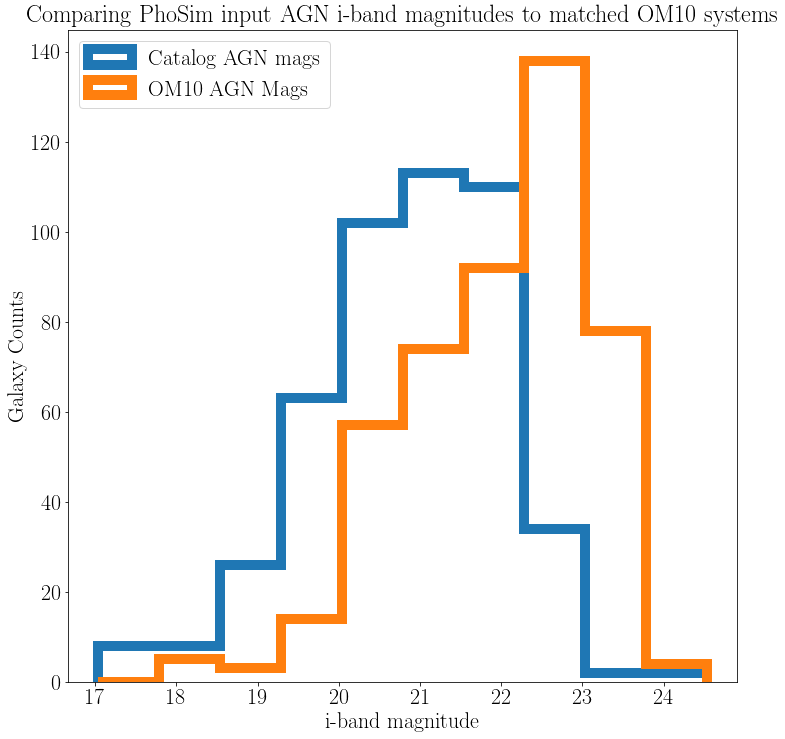

In [35]:
fig = plt.figure(figsize=(12,12))
mpl.rcParams.update({'font.size': 22})
n, bins, p = plt.hist(catalog_agn_mags, histtype='step', label='Catalog AGN mags', lw=10)
plt.hist(om10_agn_mags, bins=bins, histtype='step', label='OM10 AGN Mags', lw=10)
plt.title('Comparing PhoSim input AGN i-band magnitudes to matched OM10 systems', size=24)
plt.xlabel('i-band magnitude')
plt.ylabel('Galaxy Counts')
plt.legend(loc=2)

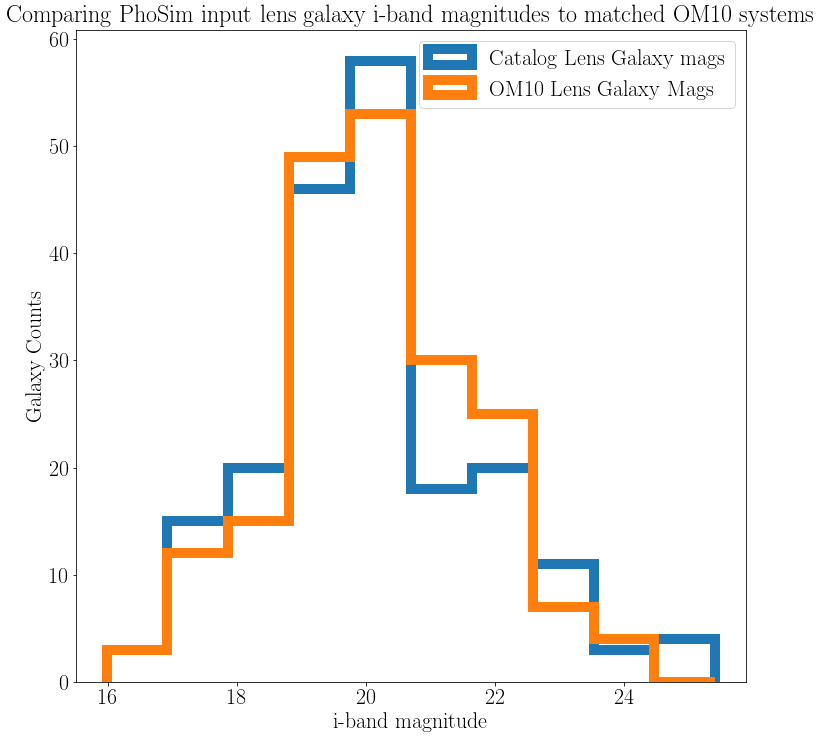

In [36]:
fig = plt.figure(figsize=(12,12))
mpl.rcParams.update({'font.size': 22})
n, bins, p = plt.hist(catalog_lens_gal_mags, histtype='step', label='Catalog Lens Galaxy mags', lw=10)
plt.hist(om10_lens_gal_mags, bins=bins, histtype='step', label='OM10 Lens Galaxy Mags', lw=10)
plt.title('Comparing PhoSim input lens galaxy i-band magnitudes to matched OM10 systems', size=24)
plt.xlabel('i-band magnitude')
plt.ylabel('Galaxy Counts')
plt.legend()

The mismatches in the plots above are most likely due to errors in the sprinkler discovered while writing this note:

1. When matching AGN magnitudes the sprinkler should redshift the AGN SED before finding the magnitude scaling to match the OM10 I-band magnitudes. It currently matches the rest frame AGN SED to the observed OM10 I-band magnitudes. 
2. When calculating the magnitude scaling for the lens galaxy it should use the associated lens galaxy SED in the updated Twinkles-OM10 catalogs instead of the generic LRG SED we included as a placeholder originally. It should also include the redshift when calculating the magnitude scaling.

The correct method for calculating the expected magnitude (before background effects) in PhoSim is used to make the plots above and shows the results that these errors have on the inputs. For the lens galaxies with smaller redshifts the effects seem to be small and since all the SEDs used in the catalog should be similar to our LRG placeholder it doesn't seem that these effects were significant either. The errors do seem significant in our lensed AGN however. Our PhoSim inputs seem shifted to be brighter than they should be according to OM10.

## Discussion and Conclusions

JBK and PJM to iterate on:

`sprinkler` seems to work well, inserting lensed quasars into PhoSim inputs. Speed of operation? Is this the rate-limiting step? 

>The `sprinkler` adds ~19% in a test on my laptop to the instance catalog generation with full density in the sprinkling step. Decreasing the density did not actually result in a significant time savings. Perhaps we could do some more caching to decrease this if it's a blocker to more general use, but considering the time we spend on instance catalog generation versus image generation I don't see this as a large problem.

Scaling up to larger sky areas - any problems foreseen?

>Other than the added time for instance catalog generation I don't see any problems in the future.

Quasar host galaxies are ignored for now, but could be matched and inserted (Li and Wiesner in prep).

>I have tested this during the SLAC Hack Day 2017 and I have a branch with this work that could be used to iterate with PhoSim when Nan and Matt are ready.

Lensed supernovae? OM10 produced a mock SN catalog that could be used.

>This is certainly something we could add as a sprinkler add-on.

# Appendix: LSST DESC Notes `ipynb` Reference

## References

[Liao K. et al., 2015, ApJ, 800, 26](https://arxiv.org/abs/1409.1254)

[Sonnenfeld A. et al., 2013, ApJ, 777, 98](https://arxiv.org/abs/1307.4759)